<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#dhSegment-demonstration" data-toc-modified-id="dhSegment-demonstration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>dhSegment demonstration</a></span><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Preparing-the-data" data-toc-modified-id="Preparing-the-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Preparing the data</a></span></li><li><span><a href="#Training-the-model" data-toc-modified-id="Training-the-model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Training the model</a></span></li><li><span><a href="#Inference-and-new-annotations" data-toc-modified-id="Inference-and-new-annotations-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Inference and new annotations</a></span></li></ul></li></ul></div>

<a href="https://colab.research.google.com/github/dhlab-epfl/dhSegment-torch/blob/master/demo/dhSegment_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# dhSegment demonstration

This notebook will show a demonstration which will:
1. Read an set of annotated images and produce the necessary data for training dhSegment
2. Train a dhSegment model
3. Use the dhSegment model to infer a semantic segmentation map

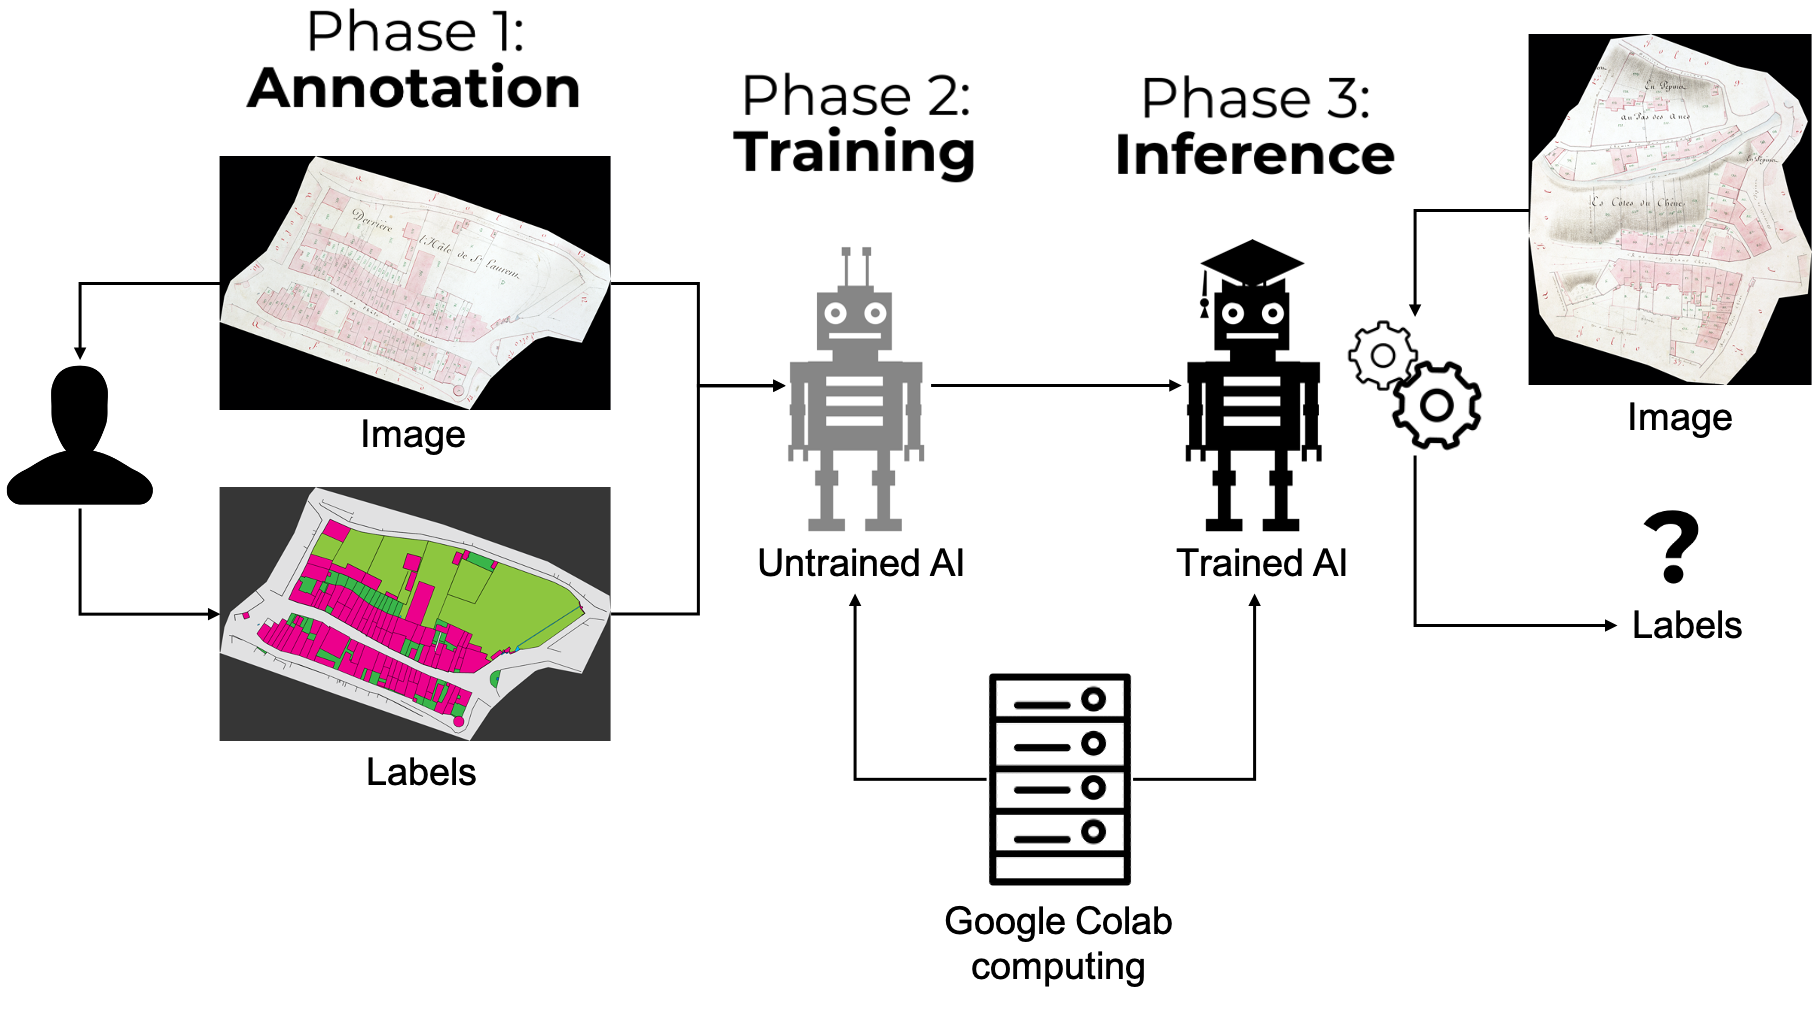

All you have to do is run the cells one by one, from first to last, using the arrow located at the top left corner of each cell.

## Setup

### Install requirements

The first 3 cells install dhSegment on the colab notebook, make the necessary imports and load the tensorboard extension to see the training process.

In [ ]:
!pip install git+https://github.com/martinblech/xmltodict@master
!pip install git+https://github.com/dhlab-epfl/dhSegment-torch.git@master

In [ ]:
from dh_segment_torch.config import Params

from dh_segment_torch.data import DataSplitter
from dh_segment_torch.data.annotation import AnnotationWriter

from dh_segment_torch.training import Trainer

from dh_segment_torch.inference import PredictProcess
from dh_segment_torch.post_processing import PostProcessingPipeline

import os, glob, json, cv2, collections
import torch

import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageColor

import cv2, glob, os, xmltodict, collections
import xml.etree.ElementTree as ET

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

### Setup Google Colab

This cell allows to link the Google colab notebook to your Google drive. It will ask you to provide a specific code to authorize the access.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In order to be able to train dhSegment effectively, a GPU (Graphics Processing Unit) is necessary, the following cell will enable the GPU of Google Colab.

If the cell gives an error, check that you have a 'GPU' runtime in the menu : Runtime > Change Runtime Type > Hardware Accelerator. Then rerun all the above cells again.

In [ ]:
assert torch.cuda.device_count() >= 1

print("The GPU has %.2f GB of memory."%(torch.cuda.get_device_properties(0).total_memory//1024**2/1000))

## CVAT patch

A patch function to convert CVAT to proper annotation format

In [ ]:
def drawCVATdataset(data_path, lines_thickness: int = 2, contours_thickness: int = 2, 
                    contours_color: str = '#FFFFFF'):
    
    def getObjectSize(object_, object_type):

        if object_type == 'polygon':
            points = np.array([[float(pt) for pt in point.split(',')] for point in object_[
                '@points'].split(';')])
            extent = np.max(points, axis=0)-np.min(points, axis=0)

            return extent[0]*extent[1]

        elif object_type == 'box':
            return (float(object_['@xbr'])-float(object_['@xtl']))*(float(object_['@ybr'])-float(object_['@ytl']))
        
    def drawObject(object_, object_type='polygon'):

        if object_type == 'polygon':
            points = np.ravel(np.array([[float(pt) for pt in point.split(',')] for point in object_[
                '@points'].split(';')])).tolist()
            draw.polygon(points, fill=classes[object_['@label']])
            if contours_thickness > 0:
                draw.line(points + points[:2], fill=contours_color, width=contours_thickness)
        elif object_type == 'polyline':
            points = np.ravel(np.array([[float(pt) for pt in point.split(',')] for point in object_[
                '@points'].split(';')])).tolist()
            draw.line(points, fill=classes[object_['@label']], width=contours_thickness)
        elif object_type == 'box':
            points = [float(object_['@xtl']), float(object_['@ytl']), float(object_['@xbr']), float(object_['@ybr'])]
            draw.rectangle(points, fill=classes[object_['@label']], outline=contours_color, width=contours_thickness)
        elif object_type == 'points':
            points = [[float(pt) for pt in point.split(',')] for point in object_[
                '@points'].split(';')]
            for pt in points:
                point = np.ravel(np.array([(np.array(pt)-(lines_thickness/2)), 
                                           (np.array(pt)+(lines_thickness/2))])).tolist()
                draw.ellipse(point, fill=classes[object_['@label']], width=0)

    xml_path = glob.glob('{}/annotations.xml'.format(data_path))

    if len(xml_path) == 0:
        raise Exception("No annotations file found")
    elif len(xml_path) > 1:
        raise Exception("More than one annotation file found")

    tree = ET.parse(xml_path[0])
    root = tree.getroot()
    dico = xmltodict.parse(ET.tostring(root))

    labels_path = os.path.join(xml_path[0].replace('annotations.xml', 'labels'))
    os.makedirs(labels_path, exist_ok=True)

    classes = {'background': '#000000'}
    for class_ in dico['annotations']['meta']['task']['labels']['label']:
        classes[class_['name']] = class_['color']
    if contours_thickness > 0:
      classes['contours_color'] = contours_color

    labels_list, images_list = [], []
    for image in dico['annotations']['image']:
        if ('box' in image.keys()) or ('polygon' in image.keys()) or (
            'polyline' in image.keys())  or ('points' in image.keys()):
            canvas = Image.fromarray(np.zeros((int(image['@height']), int(image['@width']), 3), dtype='uint8'))
            draw = ImageDraw.Draw(canvas)

            areal_objects = []
            for object_type in ['polygon', 'box']:
                if (object_type in image.keys()):
                    if type(image[object_type]) == collections.OrderedDict:
                        bbox_area = getObjectSize(image[object_type], object_type)
                        areal_objects.append({'object': image[object_type], 'type': object_type, 'area': bbox_area})
                    else:
                        for object_ in image[object_type]:
                            bbox_area = getObjectSize(object_, object_type)
                            areal_objects.append({'object': object_, 'type': object_type, 'area': bbox_area})

            if len(areal_objects) > 0:
                df_areal_objects = pd.DataFrame(areal_objects).sort_values(by='area', ascending=False)
                for i, row in df_areal_objects.iterrows():
                    drawObject(row['object'], row['type'])
            if lines_thickness > 0:
                for object_type in ['polyline', 'points']:
                    if (object_type in image.keys()):
                        if type(image[object_type]) == collections.OrderedDict:
                            drawObject(image[object_type], object_type)
                        else:
                            for object_ in image[object_type]:
                                drawObject(object_, object_type)

            label_path = os.path.join(labels_path, f"{image['@name'][:-4]}.png")
            labels_list.append(label_path)
            images_list.append(os.path.join(labels_path.replace('/labels', '/images'), image['@name']))
            canvas.save(label_path, format='PNG')
      
    return classes, images_list, labels_list

## Preparing the data

The following cell contains the parameters for loading the data and creating the necessary data for training.

Important parameters are
- `file_path` which is the path to the annotation file.
- `attrib_name` which is the name of the attribute to consider in the via file
- `images_dir` which is the directory containing the images (if not using iiif)

Prior to running this cell, you should ensure that the images and annotated labels are found in your Google drive folder, in two separate folders `images`, respectively `labels`, found in your specific `data_path`.

To see if the file are there, you can click on the folder icon in the left panel and mount your own GDrive account.

In [ ]:
# Change this parameter to your folder
folder_name = 'TMA_dhSegment'

params = {
    'data_path' : '/content/drive/My Drive/{}/data'.format(folder_name), # Path to write the data
    'data_splitter': {'train_ratio': 0.8, 'val_ratio': 0.2, 'test_ratio': 0.0}, # splitting ratio of the data
    'copy_images': True, # Whether to copy the images
    'overwrite': True, # Whether to overwrite the images
    'progress': True # Whether to show progress
}

data_path = params.pop("data_path")

color_label = {
    'path': os.path.join(data_path, "color_labels.json"),
    'colors': {
        'background': '#000000', # RGB
        'cardboard': '#2a7dd1', # RGB
        'picture': '#fa3253' # RGB
    }
}

CVAT_convert = {
    'convert_from_CVAT': True,
    'lines_thickness': 0,
    'contours_thickness': 0,
    'contours_color': '#FFFFFF'
}

### Process parameters

The following cell prepares the data according to the parameters defined above.

In [ ]:
num_processes = params.pop("num_processes", 4)

relative_path = params.pop("relative_path", True)

params.setdefault("labels_dir", os.path.join(data_path, "labels"))
labels_dir = params.get("labels_dir")

params.setdefault("images_dir", os.path.join(data_path, "images"))
images_dir = params.get("images_dir")

params.setdefault("color_labels_file_path", os.path.join(data_path, "color_labels.json"))
params.setdefault("csv_path", os.path.join(data_path, "data.csv"))

data_splitter_params = params.pop("data_splitter", None)
train_csv_path = params.pop("train_csv", os.path.join(data_path, "train.csv"))
val_csv_path = params.pop("val_csv", os.path.join(data_path, "val.csv"))
test_csv_path = params.pop("test_csv", os.path.join(data_path, "test.csv"))

params.setdefault("type", "image")

if CVAT_convert['convert_from_CVAT']:
    classes, images_list, labels_list = drawCVATdataset(data_path, 
          CVAT_convert['lines_thickness'], CVAT_convert['contours_thickness'], 
          CVAT_convert['contours_color'])
    labels_dir = labels_list[0][:-1-len(labels_list[0].split('/')[-1])]
    images_dir = images_list[0][:-1-len(images_list[0].split('/')[-1])]
    color_label['colors'] = classes

else:
    labels_list = sorted(glob.glob(os.path.join(labels_dir, '*.*')))
    images_list = sorted(glob.glob(os.path.join(images_dir, '*.*')))

data = pd.DataFrame({'image': images_list, 'label': labels_list})
data.to_csv(params['csv_path'], header=False, index=False)

if relative_path:
    data['image'] = data['image'].apply(lambda path: os.path.join("images", os.path.basename(path)))
    data['label'] = data['label'].apply(lambda path: os.path.join("labels", os.path.basename(path)))

if data_splitter_params:
    data_splitter = DataSplitter.from_params(data_splitter_params)
    data_splitter.split_data(data, train_csv_path, val_csv_path, test_csv_path)

for class_name in color_label['colors'].keys():
    if type(color_label['colors'][class_name]) == str:
        color_label['colors'][class_name] = list(ImageColor.getcolor(
            color_label['colors'][class_name], "RGB"))

with open(color_label['path'], 'w') as outfile:
    json.dump({'colors': list(color_label['colors'].values()),
              'one_hot_encoding': None,
              'labels': list(color_label['colors'].keys())}, outfile)

## Training the model

The following cell contains the configuration for the model and its training.

The defaults should be fine for most use cases.

The only parameter that may require tweaking is the batch size that needs to be set according to the amount of memory the GPU has. For 15-16 GB of memory (what you normally get on Colab), a batch size of 4 is fine for images of c.a. 1M pixels (1000x1000), otherwise a batch size of 2 or less should be set.

### Parameters

In [ ]:
params = {
        "color_labels": {"label_json_file": os.path.join(data_path, "color_labels.json")}, # Color labels produced before
        "train_dataset": {
            "type": "image_csv", # Image csv dataset
            "csv_filename":  os.path.join(data_path, "train.csv"),
            "base_dir": data_path,
            "repeat_dataset": 1,
            "compose": {"transforms": []}#[{"type": "fixed_size_resize", "output_size": 7.5e5}]} # Resize to a fixed size, could add other transformations.
        },
        "val_dataset": {
            "type": "image_csv", # Validation dataset
            "csv_filename": os.path.join(data_path, "val.csv"),
            "base_dir": data_path,
            "compose": {"transforms": []}#[{"type": "fixed_size_resize", "output_size": 7.5e5}]} # Resize to a fixed size, could add other transformations.
        },
        "model": { # Model definition, original dhSegment
            "encoder": "resnet50", 
            "decoder": {
                "decoder_channels": [512, 256, 128, 64, 32],
                "max_channels": 512
            }
        },
        "metrics": [['miou', 'iou'], ['iou', {"type": 'iou', "average": None}], 'precision'], # Metrics to compute
        "optimizer": {"lr": 5e-5}, # Learning rate
        "lr_scheduler": {"type": "exponential", "gamma": 0.9995}, # Exponential decreasing learning rate
        "val_metric": "+miou", # Metric to observe to consider a model better than another, the + indicates that we want to maximize
        "early_stopping": {"patience": 50}, # Number of validation steps without increase to tolerate, stops if reached
        "model_out_dir": "/content/drive/My Drive/{}/models".format(folder_name), # Path to model output
        "num_epochs": 200, # Number of epochs for training
        "evaluate_every_epoch": 2, # Number of epochs between each validation of the model
        "batch_size": 4, # Batch size (to be changed if the allocated GPU has little memory)
        "num_data_workers": 0,
        "track_train_metrics": False,
        "loggers": [
           {"type": 'tensorboard', "log_dir": "/content/drive/My Drive/{}/tensorboard/log".format(folder_name), 
            "log_every": 25, "log_images_every": 100}, # Tensorboard logging
           ]
    }


### Start training

The following cell generates the trainer from the parameters defined above and trains the model.

The training process can then be observed in the below tensorboard window.

The can be interrupted if a good enough result has been obtained has checkpoints are automatically created.

In [ ]:
trainer = Trainer.from_params(params)
trainer.train()

The following cell will start and launch a Tensorboard instance. If it fails, relaunch the cell and wait until you see the Tensorboard orange bar.

In [ ]:
tensorboard --logdir "/content/drive/My Drive/{}/tensorboard/log".format(folder_name)

## Inference

The inference corresponds to the production stage. It allows the neural network to work on images it has never "seen" before. It makes predictions on these images which are translated into the form of probability maps. By displaying only the maximum probability for each pixel, the optimal result is obtained. This result can then be stored for further computer manipulation, such as creating a database or digital collection.

### Parameters

In [ ]:
dataset_params = {
    "type": "folder",
    "folder": "/content/drive/My Drive/{}/data/images".format(folder_name),
    "pre_processing": {"transforms": []}#{"type": "fixed_size_resize", "output_size": 1e6}]}
}

model_params = {
    "model": {
            "encoder": "resnet50",
            "decoder": {"decoder_channels": [512, 256, 128, 64, 32], "max_channels": 512}
        },
        "num_classes": 3,
        "model_state_dict": sorted(glob.glob("/content/drive/My Drive/{}/models/best_model_checkpoint_miou=*.pth".format(folder_name)))[-1],
        "device": "cuda:0"
}

process_params = Params({
    'data': dataset_params,
    'model': model_params,
    'batch_size': 4,
    'num_workers': 4,
    'add_path': True
})

### Compute prediction

In [ ]:
output_dir = "/content/drive/My Drive/{}/predictions".format(folder_name)
os.makedirs(output_dir, exist_ok=True)
predict_annots = PredictProcess.from_params(process_params)
predict_annots.process_to_probas_files(output_dir)
results = [np.load(path) for path in sorted(glob.glob(os.path.join(output_dir, '*.npy')))]
images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in sorted(glob.glob(os.path.join(data_path, 'images', '*.*')))]

#### Image
Choose an image (`image_nb`) for which you want to check the result

In [ ]:
image_nb = 0
Image.fromarray(images[image_nb])

#### Probability map
For a given class (`class_nb`). The lighter pixels correspond to a higher class probability

In [ ]:
class_nb = 2
Image.fromarray((np.around(results[image_nb][class_nb]*255)).astype('uint8'))

#### Most probable classes

In [ ]:
image = np.argmax(results[image_nb], axis=0).astype('uint8')
colors = list(color_label['colors'].values())
canvas = np.zeros((image.shape[0], image.shape[1], 3)).astype('uint8')
for i, color in enumerate(colors):
  canvas[image == i] = color
Image.fromarray(canvas)

In [ ]:
Image.fromarray(canvas//2 + images[image_nb]//2)

In [ ]:
mask = (image == class_nb).astype('uint8')*255
x, y, w, h = cv2.boundingRect(mask)
cut = cv2.merge((images[image_nb], mask))[y:y+h, x:x+w]
Image.fromarray(cut)